# 虚拟换装之VOGUE

当代手机购物浪潮下，人们往往只能通过观察买家秀的着装效果来感受衣服自己穿是否合适，无法前往实体店试衣成了一大难题，从而造成的退货、换货现象频发。虚拟试穿能够通过计算方式可视化人所感兴趣的服装，从而增强购物体验，并有助于降低因生产过剩和退货造成的环境成本。为此，Kathleen M Lewis、Srivatsan Varadharajan、和Ira Kemelmacher-Shlizerman引入了一种新的可控图像生成算法，名为VOGUE，它将一个图像中的个人指定部位与另一个图像中的服装形状和细节无缝集成。其具体做法为：首先在10万张以2D人体姿势照片上训练一个修改后的StyleGAN2网络，然后给定一组人物图像和服装图像，求出每层的最佳插值系数用于生成第一个输入图像的人穿着来自第二个图像的服装的照片。本任务将借助MindSpore框架来实现VOGUE的应用。

## 模型简介

VOGUE在StyleGAN2的基础上，引入了姿态数据，使得模型可以适用于虚拟换装。该模型采用编码器输出的热图作为生成器中样式块的输入，并采用插值的方式寻找最优试穿效果。训练损失与GAN相似，生成器目的在于让鉴别器无法区分，鉴别器则致力于区分开生成图片与真实图片。如下图所示，从效果上来看，可以实现较强的虚拟试穿效果。

<img src='./images/grid_pytorch.png' width=50% height=50%/>

## 数据处理

### 数据准备

本案例使用Inshop数据集。请提前下载好该[数据集](https://drive.google.com/file/d/1r_Pz2gk1Sp2sjYS7cj9oYUMbLGo9EyZS/view?usp=sharing),并将其保存在`./dataset/`目录下。

本数据集共有48674张图像，由多位模特身着不同衣服和裤子拍摄，包括正面照，侧面照，背面照等，图片大小均为256×256，数据集图片如下图所示：

<img src='./images/show.png' width=50% height=50%/>

解压后的数据集文件目录如下：

```text

./dataset/
    └── inshopclothes
    |    └── train
    |    |      ├── fashionMENDenimid0000008001_1front.jpg
    |    |      ├── fashionMENDenimid0000008001_2side.jpg
    |    |      ├── fashionMENDenimid0000008001_3back.jpg
    |    |           ......
```

### 数据转换

为了更好的导入数据集，我们强烈建议您使用`src/vogue_dataset_convert.py`将文件夹形式的数据集转化为zip格式。

首先添加代码执行路径。

In [2]:
import sys
sys.path.append('./src/')

接着进行数据转换。

In [2]:
import argparse

from vogue_dataset_convert import convert_dataset

def parse_args():
    """Parameter configuration"""
    args = argparse.ArgumentParser()
    args.add_argument('--source', help='Directory for input dataset',
                      default='dataset/inshopclothes/', metavar='PATH')
    args.add_argument('--dest', help='Output archive name for output dataset, must end with "zip"',
                      default='dataset/data.zip', metavar='PATH')
    args.add_argument('--max-images', help='Output only up to `max-images` images',
                      type=int, default=None)
    args.add_argument('--resize-filter', help='Filter to use when resizing images',
                      choices=['box', 'lanczos'], default='lanczos')
    args.add_argument('--transform', help='Input crop/resize mode, optional',
                      choices=['center-crop', 'center-crop-wide'])
    args.add_argument('--width', help='Output width, optional', type=int)
    args.add_argument('--height', help='Output height, optional', type=int)
    args = args.parse_known_args()[0]
    return args


convert_dataset(parse_args())
print('Dataset convert finished.')

100%|███████████████████████████████████████████████████████████████████████████| 48674/48674 [02:32<00:00, 318.37it/s]


Dataset convert finished.


### 数据加载

通过数据集加载接口`src/process_datasets/inshop.py`加载数据集。

In [3]:
from process_datasets.inshop import Inshop

data_dir = './dataset/data.zip'
posefile = 'src/pose-annotations.csv'
mirror = 1
batch_size = 2

# load dataset
training_set = Inshop(path=data_dir, pose_file=posefile, resize=256, use_labels=False,
                      max_size=48674, xflip=mirror, batch_size=batch_size)
print('Dataset load finished.')

Dataset load finished.


### 数据集可视化

运行以下代码，通过matplotlib可视化数据集中的随机四十张图片。

img shape:  (256, 256)
Plotting images...


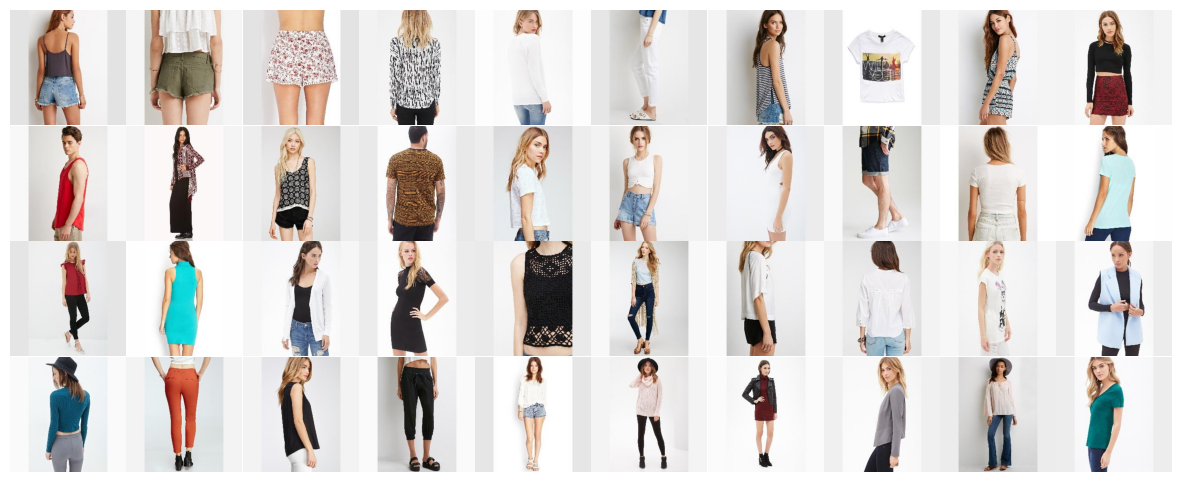

Plotting finished.


In [4]:
import os
import random

import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

random.seed(100)
path = './dataset/inshopclothes/train/'
dataset = sorted(os.listdir(path))
img = PIL.Image.open(path + dataset[0])
print('img shape: ', img.size)

print('Plotting images...')
plt.figure(figsize=(15, 6))
for i in range(1, 41):
    plt.subplot(4, 10, i)
    num = random.randint(0, len(dataset))
    image = PIL.Image.open(path + dataset[num])
    plt.imshow(np.array(image))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")
plt.show()
print('Plotting finished.')

## 构建网络

<img src='./images/architecture.png'/>

网络基于StyleGAN2做了修改，引入了人体姿态。上图中，Mapping网络将两个潜在代码$z_1^+$和$z_2^+$（表示两个输入图像）和一个姿态热图作为输入给到姿态条件化的StyleGAN2生成器（灰色）。生成器通过使用插值系数q在潜在代码之间进行插值，生成试穿图像及其相应的分割。通过最小化插值系数空间上的损失函数，我们能够将服装图像中的服装传输到人物图像中。

### 生成器

由于VOGUE网络基于StyleGAN2，这里简单介绍一下StyleGAN与StyleGAN2的网络结构，但这并非本文重点。

<img src='./images/stylegan.png' width=50% height=50%/>

我们首先将输入映射到中间潜在空间W，然后该空间通过每个卷积层的自适应实例规范化（AdaIN）控制生成器。在评估非线性之前，在每次卷积之后添加高斯噪声。这里，A表示学习的仿射变换，B将学习的每通道比例因子应用于噪声输入。映射（Mapping）网络$f$由8层组成，合成（Synthesis）网络$g$由18层组成，每个分辨率2层（$4^2$-$1024^2$）。最后一层的输出使用一个单独的1×1卷积转换为RGB。我们的生成器共有2620万个可训练参数，而传统生成器只有2310万个。

<img src='./images/stylegan2.png' width=80% height=80%/>

StyleGAN2基于StyleGAN，重新设计了Synthesis网络的结构。（a） 原始样式，其中A表示从W学习的仿射变换，并生成对应的样式，B表示噪声传播操作。（b） 有完整的细节的相同结构。在这里，我们将AdaIN分解为显式归一化，然后再进行调制，这两种方法都基于每个特征图的平均值和标准差。我们还对学习到的权重（$w$）、偏差（$b$）和常量输入（$c$）进行了注释，并重新绘制了灰色框，以便每个框都有一种样式处于活动状态。激活函数（leaky ReLU）总是在添加偏置后立即应用。（c） 我们对原始架构进行了几处更改，这些更改在正文中得到了证实。我们在开始时删除了一些冗余操作，将b和B的加操作移动到样式的活动区域之外，并且只调整每个特征映射的标准差。（d） 修改后的体系结构使我们能够用“解调”操作代替实例规范化，我们将其应用于与每个卷积层关联的权重。

<img src='./images/generator.png' width=50% height=50%/>

VOGUE的生成器基于StyleGAN2生成器，引入姿态调节模块。该网络输出RGB图像以及每层图像的分割。传统的StyleGAN2第一个样式块的输入为一常量，这里更改为编码后的姿态热图。姿态热图由姿态数据通过一个姿态encoder生成，姿态数据被保存在`pose-annotations.csv`文件中。

In [5]:
import numpy as np

from mindspore import nn, ops, Tensor
import mindspore as ms

from vogue_utils import upfirdn2d
from models.vogue_block import FullyConnectedLayer, MappingNetwork, resample_filter

In [6]:
class Generator(nn.Cell):
    """
    Generator.

    Args:
        z_dim (int): Input latent (Z) dimensionality.
        c_dim (int): Conditioning label (C) dimensionality.
        w_dim (int): Intermediate latent (W) dimensionality.
        img_resolution (int): Output image resolution.
        img_channels (int): Number of output color channels.
        batch_size (int): Batch size. Default: 1.
        train (bool): True: train, False: infer. Default: False.
        mapping_kwargs (dict): Arguments for MappingNetwork. Default: None.
        synthesis_kwargs (dict): Arguments for SynthesisNetwork. Default: None.

    Inputs:
        - **z** (Tensor) - Latent tensor.
        - **c** (Tensor) - Label tensor.
        - **pose** (Tensor) - Pose tensor.
        - **truncation_psi** (int) - Truncation coefficient. Default: 1.
        - **truncation_cutoff** (int) - Truncation cutoff if truncation_psi != 1. Default: None.
        - **ret_pose** (bool) - Need to return the pose feature. Default: False.
        - **noise_mode** (int) - Noise mode 0: const, 1: random. Default: 0.

    Outputs:
        Tensor, output image.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> generator = Generator(z_dim, c_dim, w_dim, img_resolution, img_channels, mapping_kwargs)
        >>> x = generator(z, c, pose)
    """
    def __init__(self, z_dim, c_dim, w_dim, img_resolution, img_channels, batch_size=1, train=False,
                 mapping_kwargs=None, synthesis_kwargs=None):
        super().__init__()
        self.z_dim = z_dim
        self.c_dim = c_dim
        self.w_dim = w_dim
        self.img_resolution = img_resolution
        self.img_channels = img_channels
        self.batch_size = batch_size
        self.train = train
        self.synthesis = SynthesisNetwork(w_dim=w_dim, img_resolution=img_resolution, img_channels=img_channels,
                                          batch_size=batch_size, train=train, **synthesis_kwargs)
        self.num_ws = self.synthesis.num_ws
        self.mapping = MappingNetwork(z_dim=z_dim, c_dim=c_dim, w_dim=w_dim, num_ws=self.num_ws, **mapping_kwargs)

    def construct(self, z, c, pose, truncation_psi=1, truncation_cutoff=None, ret_pose=False, noise_mode=0):
        """Generator construct"""
        ws = self.mapping(z, c, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)
        return self.synthesis(ws, pose, ret_pose=ret_pose, noise_mode=noise_mode)

### 映射网络

如前所述，映射网络将潜在变量z通过8个全连接层映射到中间潜在空间W。

In [7]:
class MappingNetwork(nn.Cell):
    """
    Mapping Network.

    Args:
        z_dim (int): Input latent (Z) dimensionality, 0 = no latent.
        c_dim (int): Conditioning label (C) dimensionality, 0 = no label.
        w_dim (int): Intermediate latent (W) dimensionality.
        num_ws (int): Number of intermediate latents to output, None = do not broadcast.
        num_layers (int): Number of mapping layers. Default: 8.
        embed_features (bool): Label embedding dimensionality. Default: None.
        layer_features (bool): Number of intermediate features in the mapping layers,
            None = same as w_dim. Default: None.
        activation (str): The activation function: 'relu', 'lrelu', etc. Default: 'lrelu'.
        lr_multiplier (float): Learning rate multiplier for the mapping layers. Default: 0.01.
        w_avg_beta (float): Decay for tracking the moving average of W during training,
            None = do not track. Default: 0.995.

    Inputs:
        - **z** (Tensor) - Latent tensor.
        - **c** (Tensor) - Label tensor.
        - **truncation_psi** (int) - Truncation coefficient. Default: 1.
        - **truncation_cutoff** (int) - Truncation cutoff if truncation_psi != 1. Default: None.
        - **skip_w_avg_update** (bool) - Need to skip the w_avg undate. Default: False.

    Outputs:
        Tensor, mapping network output tensor.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> mapping = MappingNetwork(z_dim, c_dim, w_dim, num_ws)
        >>> ws = mapping(z, c)
    """
    def __init__(self, z_dim, c_dim, w_dim, num_ws, num_layers=8, embed_features=None, layer_features=None,
                 activation='lrelu', lr_multiplier=0.01, w_avg_beta=0.995):
        super().__init__()
        self.z_dim = z_dim
        self.c_dim = c_dim
        self.w_dim = w_dim
        self.num_ws = num_ws
        self.num_layers = num_layers
        self.w_avg_beta = w_avg_beta
        zeros = ops.Zeros()

        if embed_features is None:
            embed_features = w_dim
        if c_dim == 0:
            embed_features = 0
        if layer_features is None:
            layer_features = w_dim
        features_list = [z_dim + embed_features] + [layer_features] * (num_layers - 1) + [w_dim]

        if c_dim > 0:
            self.embed = FullyConnectedLayer(c_dim, embed_features)
        self.blocks = nn.CellList()
        for idx in range(num_layers):
            in_features = features_list[idx]
            out_features = features_list[idx + 1]
            layer = FullyConnectedLayer(in_features, out_features, activation=activation, lr_multiplier=lr_multiplier)
            self.blocks.append(layer)

        if num_ws is not None and w_avg_beta is not None:
            self.w_avg = Parameter(zeros(w_dim, ms.float32))

    def construct(self, z, c, truncation_psi=1, truncation_cutoff=None, skip_w_avg_update=False):
        """Mapping network construct"""
        concat = ops.Concat(axis=1)
        x = None
        if self.z_dim > 0:
            x = normalize_2nd_moment(z)
        if self.c_dim > 0:
            y = normalize_2nd_moment(self.embed(c))
            x = concat((x, y)) if x is not None else y

        for layer in self.blocks:
            x = layer(x)

        if self.w_avg_beta is not None and self.training and not skip_w_avg_update:
            self.w_avg = (x.mean(axis=0) + (self.w_avg - x.mean(axis=0)) * self.w_avg_beta).copy()

        if self.num_ws is not None:
            x = x.expand_dims(axis=1).repeat(self.num_ws, axis=1)

        if truncation_psi != 1:
            if self.num_ws is None or truncation_cutoff is None:
                x = self.w_avg + (x - self.w_avg) * truncation_psi
            else:
                x[:, :truncation_cutoff] = self.w_avg + (x[:, :truncation_cutoff] - self.w_avg) * truncation_psi
        return x

### 合成网络

合成网络在不同分辨率下进行上采样，分辨率从2到1024，共9个，每个分辨率对应2层，共18层网络，其中最后一层转换为RGB。

In [8]:
class SynthesisBlock(nn.Cell):
    """
    Synthesis Block.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        w_dim (int): Intermediate latent (W) dimensionality.
        resolution (int): Resolution of this layer.
        img_channels (int): Number of output color channels.
        is_last (bool): Is this the last block?
        architecture (str): Architecture: 'orig', 'skip'. Default: 'skip'.
        conv_clamp (bool): Clamp the output to +-X, None = disable clamping. Default: None.
        use_fp16 (bool): Use FP16 for this block? Default: False.
        batch_size (int): Batch size. Default: 1.
        train (bool): True: train, False: infer. Default: False.
        layer_kwargs (dict): Arguments for SynthesisLayer.

    Inputs:
        - **x** (Tensor) - Input feature.
        - **img** (Tensor) - Input image.
        - **ws** (Tensor) - Intermediate latents.
        - **force_fp32** (bool) - If force the input to float32. Default: False.
        - **fused_modconv** (bool) - Perform modulation, convolution, and demodulation as a single fused operation?
           . Default: True.
        - **noise_mode** (int) - Noise mode 0: const, 1: random. Default: 0.

    Outputs:
        Tensor, output feature.
        Tensor, output image.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> block = SynthesisBlock(in_channels, out_channels, w_dim, resolution, img_channels, is_last)
        >>> x, img = block(x, img, ws)
    """
    def __init__(self, in_channels, out_channels, w_dim, resolution, img_channels, is_last, architecture='skip',
                 conv_clamp=None, use_fp16=False, batch_size=1, train=False, **layer_kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.w_dim = w_dim
        self.resolution = resolution
        self.img_channels = img_channels
        self.is_last = is_last
        self.architecture = architecture
        self.use_fp16 = use_fp16
        self.size = batch_size
        self.train = train
        self.num_conv = 0
        self.num_torgb = 0

        if in_channels != 0:
            self.conv0 = SynthesisLayer(in_channels, out_channels, w_dim=w_dim, resolution=resolution, up=2,
                                        conv_clamp=conv_clamp, **layer_kwargs)
            self.num_conv += 1

        self.conv1 = SynthesisLayer(out_channels, out_channels, w_dim=w_dim, resolution=resolution,
                                    conv_clamp=conv_clamp, **layer_kwargs)
        self.num_conv += 1

        if is_last or architecture == 'skip':
            self.torgb = ToRGBLayer(out_channels, img_channels, w_dim=w_dim, conv_clamp=conv_clamp)
            self.num_torgb += 1

        self.name_list = ['conv2d'] * 2 + (['transpose2d'] + ['conv2d'] * 4) * 6
        self.dtype_list = ['float32' for _ in range(len(self.name_list))]

        if self.train:
            self.input_list = [(self.size, 512, 4, 4), (self.size, 512, 4, 4), (self.size, 512, 4, 4),
                               (self.size, 512, 11, 11), (self.size, 512, 8, 8), (self.size, 3, 11, 11),
                               (self.size, 512, 8, 8), (self.size, 512, 8, 8), (self.size, 512, 19, 19),
                               (self.size, 512, 16, 16), (self.size, 3, 19, 19), (self.size, 512, 16, 16),
                               (self.size, 512, 16, 16), (self.size, 512, 35, 35), (self.size, 512, 32, 32),
                               (self.size, 3, 35, 35), (self.size, 512, 32, 32), (self.size, 512, 32, 32),
                               (self.size, 256, 67, 67), (self.size, 256, 64, 64), (self.size, 3, 67, 67),
                               (self.size, 256, 64, 64), (self.size, 256, 64, 64), (self.size, 128, 131, 131),
                               (self.size, 128, 128, 128), (self.size, 3, 131, 131), (self.size, 128, 128, 128),
                               (self.size, 128, 128, 128), (self.size, 64, 259, 259), (self.size, 64, 256, 256),
                               (self.size, 3, 259, 259), (self.size, 64, 256, 256)]

            self.weight_list = [(512, 512, 3, 3), (3, 512, 1, 1)] + \
                               [(512, 512, 3, 3), (512, 1, 4, 4), (512, 512, 3, 3), (3, 1, 4, 4), (3, 512, 1, 1)] * 3 \
                               + [(512, 256, 3, 3), (256, 1, 4, 4), (256, 256, 3, 3), (3, 1, 4, 4), (3, 256, 1, 1),
                                  (256, 128, 3, 3), (128, 1, 4, 4), (128, 128, 3, 3), (3, 1, 4, 4), (3, 128, 1, 1),
                                  (128, 64, 3, 3), (64, 1, 4, 4), (64, 64, 3, 3), (3, 1, 4, 4), (3, 64, 1, 1)]

            self.all_conv = nn.CellList([self._conv2d(512, 512, 3, 1, 1, 1, 1, 0),
                                         self._conv2d(512, 3, 1, 1, 0, 1, 1, 1),
                                         self._transpose2d(512, 512, 3, 2, 0, 1, 1, 2),
                                         self._conv2d(512, 512, 4, 1, 0, 1, 512, 3),
                                         self._conv2d(512, 512, 3, 1, 1, 1, 1, 4),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 5),
                                         self._conv2d(512, 3, 1, 1, 0, 1, 1, 6),
                                         self._transpose2d(512, 512, 3, 2, 0, 1, 1, 7),
                                         self._conv2d(512, 512, 4, 1, 0, 1, 512, 8),
                                         self._conv2d(512, 512, 3, 1, 1, 1, 1, 9),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 10),
                                         self._conv2d(512, 3, 1, 1, 0, 1, 1, 11),
                                         self._transpose2d(512, 512, 3, 2, 0, 1, 1, 12),
                                         self._conv2d(512, 512, 4, 1, 0, 1, 512, 13),
                                         self._conv2d(512, 512, 3, 1, 1, 1, 1, 14),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 15),
                                         self._conv2d(512, 3, 1, 1, 0, 1, 1, 16),
                                         self._transpose2d(512, 256, 3, 2, 0, 1, 1, 17),
                                         self._conv2d(256, 256, 4, 1, 0, 1, 256, 18),
                                         self._conv2d(256, 256, 3, 1, 1, 1, 1, 19),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 20),
                                         self._conv2d(256, 3, 1, 1, 0, 1, 1, 21),
                                         self._transpose2d(256, 128, 3, 2, 0, 1, 1, 22),
                                         self._conv2d(128, 128, 4, 1, 0, 1, 128, 23),
                                         self._conv2d(128, 128, 3, 1, 1, 1, 1, 24),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 25),
                                         self._conv2d(128, 3, 1, 1, 0, 1, 1, 26),
                                         self._transpose2d(128, 64, 3, 2, 0, 1, 1, 27),
                                         self._conv2d(64, 64, 4, 1, 0, 1, 64, 28),
                                         self._conv2d(64, 64, 3, 1, 1, 1, 1, 29),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 30),
                                         self._conv2d(64, 3, 1, 1, 0, 1, 1, 31)])
        else:
            self.input_list = [(1, 512*self.size, 4, 4), (1, 512*self.size, 4, 4), (1, 512*self.size, 4, 4),
                               (1, 512*self.size, 11, 11), (1, 512*self.size, 8, 8), (self.size, 3, 11, 11),
                               (1, 512*self.size, 8, 8), (1, 512*self.size, 8, 8), (1, 512*self.size, 19, 19),
                               (1, 512*self.size, 16, 16), (self.size, 3, 19, 19), (1, 512*self.size, 16, 16),
                               (self.size, 512, 16, 16), (self.size, 512, 35, 35), (self.size, 512, 32, 32),
                               (self.size, 3, 35, 35), (self.size, 512, 32, 32), (self.size, 512, 32, 32),
                               (self.size, 256, 67, 67), (self.size, 256, 64, 64), (self.size, 3, 67, 67),
                               (self.size, 256, 64, 64), (self.size, 256, 64, 64), (self.size, 128, 131, 131),
                               (self.size, 128, 128, 128), (self.size, 3, 131, 131), (self.size, 128, 128, 128),
                               (self.size, 128, 128, 128), (self.size, 64, 259, 259), (self.size, 64, 256, 256),
                               (self.size, 3, 259, 259), (self.size, 64, 256, 256)]

            self.weight_list = [(512*self.size, 512, 3, 3), (3*self.size, 512, 1, 1)] + \
                               [(512*self.size, 512, 3, 3), (512*self.size, 1, 4, 4), (512*self.size, 512, 3, 3),
                                (3, 1, 4, 4), (3*self.size, 512, 1, 1)] * 2 + \
                               [(512, 512, 3, 3), (512, 1, 4, 4), (512, 512, 3, 3), (3, 1, 4, 4), (3, 512, 1, 1),
                                (512, 256, 3, 3), (256, 1, 4, 4), (256, 256, 3, 3), (3, 1, 4, 4), (3, 256, 1, 1),
                                (256, 128, 3, 3), (128, 1, 4, 4), (128, 128, 3, 3), (3, 1, 4, 4), (3, 128, 1, 1),
                                (128, 64, 3, 3), (64, 1, 4, 4), (64, 64, 3, 3), (3, 1, 4, 4), (3, 64, 1, 1)]

            self.all_conv = nn.CellList([self._conv2d(512*self.size, 512*self.size, 3, 1, 1, 1, self.size, 0),
                                         self._conv2d(512*self.size, 3*self.size, 1, 1, 0, 1, self.size, 1),
                                         self._transpose2d(512*self.size, 512*self.size, 3, 2, 0, 1, self.size, 2),
                                         self._conv2d(512*self.size, 512*self.size, 4, 1, 0, 1, 512*self.size, 3),
                                         self._conv2d(512*self.size, 512*self.size, 3, 1, 1, 1, self.size, 4),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 5),
                                         self._conv2d(512*self.size, 3*self.size, 1, 1, 0, 1, self.size, 6),
                                         self._transpose2d(512*self.size, 512*self.size, 3, 2, 0, 1, self.size, 7),
                                         self._conv2d(512*self.size, 512*self.size, 4, 1, 0, 1, 512*self.size, 8),
                                         self._conv2d(512*self.size, 512*self.size, 3, 1, 1, 1, self.size, 9),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 10),
                                         self._conv2d(512*self.size, 3*self.size, 1, 1, 0, 1, self.size, 11),
                                         self._transpose2d(512, 512, 3, 2, 0, 1, 1, 12),
                                         self._conv2d(512, 512, 4, 1, 0, 1, 512, 13),
                                         self._conv2d(512, 512, 3, 1, 1, 1, 1, 14),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 15),
                                         self._conv2d(512, 3, 1, 1, 0, 1, 1, 16),
                                         self._transpose2d(512, 256, 3, 2, 0, 1, 1, 17),
                                         self._conv2d(256, 256, 4, 1, 0, 1, 256, 18),
                                         self._conv2d(256, 256, 3, 1, 1, 1, 1, 19),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 20),
                                         self._conv2d(256, 3, 1, 1, 0, 1, 1, 21),
                                         self._transpose2d(256, 128, 3, 2, 0, 1, 1, 22),
                                         self._conv2d(128, 128, 4, 1, 0, 1, 128, 23),
                                         self._conv2d(128, 128, 3, 1, 1, 1, 1, 24),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 25),
                                         self._conv2d(128, 3, 1, 1, 0, 1, 1, 26),
                                         self._transpose2d(128, 64, 3, 2, 0, 1, 1, 27),
                                         self._conv2d(64, 64, 4, 1, 0, 1, 64, 28),
                                         self._conv2d(64, 64, 3, 1, 1, 1, 1, 29),
                                         self._conv2d(3, 3, 4, 1, 0, 1, 3, 30),
                                         self._conv2d(64, 3, 1, 1, 0, 1, 1, 31)])
        self.all_conv_weight = ms.ParameterTuple(self.all_conv.get_parameters())
        for param in self.all_conv_weight:
            param.requires_grad = False
        self.all_info = [self.all_conv, self.all_conv_weight, self.input_list, self.weight_list, self.name_list]

    def _conv2d(self, in_channels, out_channels, kernel_size, stride, padding, dilation, group, num):
        """
        Conv2d operator.

        Args:
            in_channels (int): Input channel.
            out_channels (int): Output channel.
            kernel_size (int): Kernel size.
            stride (int): Stride.
            padding (int): Padding.
            dilation(int): Dilation.
            group (int): Group.
            num (int): The number of the operator in all_conv.

        Returns:
            nn.Cell, function of nn.Conv2d with given weight shape.

        Examples:
            >>> func = _conv2d(512, 512, 3, 1, 1, 1, 1, 0)
        """
        if self.dtype_list[num] == 'float32':
            func = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                             stride=stride, pad_mode="pad", padding=padding, dilation=dilation, group=group,
                             has_bias=False, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float32))
        else:
            func = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                             stride=stride, pad_mode="pad", padding=padding, dilation=dilation, group=group,
                             has_bias=False, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float16))
        return func

    def _transpose2d(self, in_channels, out_channels, kernel_size, stride, padding, dilation, group, num):
        """
        Transpose2d operator.

        Args:
            in_channels (int): Input channel.
            out_channels (int): Output channel.
            kernel_size (int): Kernel size.
            stride (int): Stride.
            padding (int): Padding.
            dilation(int): Dilation.
            group (int): Group.
            num (int): The number of the operator in all_conv.

        Returns:
            nn.Cell, function of nn.Conv2dTranspose with given weight shape.

        Examples:
            >>> func = _transpose2d(512, 512, 3, 2, 0, 1, 1, 2)
        """
        if self.dtype_list[num] == 'float32':
            func = nn.Conv2dTranspose(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                      stride=stride, pad_mode='pad', padding=padding, dilation=dilation,
                                      group=group, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float32))
        else:
            func = nn.Conv2dTranspose(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                      stride=stride, pad_mode='pad', padding=padding, dilation=dilation,
                                      group=group, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float16))
        return func


    def construct(self, x, img, ws, force_fp32=False, fused_modconv=None, noise_mode=0):
        """Synthesis block construct"""
        unstack = ops.Unstack(axis=1)
        w_iter = iter(unstack(ws))
        d_type = ms.float16 if self.use_fp16 and not force_fp32 else ms.float32
        if fused_modconv is None:
            fused_modconv = (not self.training) and (d_type == ms.float32 or x.shape[0] == 1)

        d_type = ms.float32
        if self.in_channels != 0:
            x = x.astype(d_type)

        if self.in_channels == 0:
            x = self.conv1(x, next(w_iter).astype(d_type), fused_modconv=fused_modconv, noise_mode=noise_mode,
                           all_info=self.all_info)
        else:
            x = self.conv0(x, next(w_iter).astype(d_type), fused_modconv=fused_modconv, noise_mode=noise_mode,
                           all_info=self.all_info)
            x = self.conv1(x, next(w_iter).astype(d_type), fused_modconv=fused_modconv, noise_mode=noise_mode,
                           all_info=self.all_info)

        if img is not None:
            img = upfirdn2d.upsample2d(img, resample_filter, all_info=self.all_info)
        if self.is_last or self.architecture == 'skip':
            y = self.torgb(x, next(w_iter), fused_modconv=fused_modconv, all_info=self.all_info)
            y = y.astype(ms.float32)
            img = img + y if img is not None else y

        return x, img

### 鉴别器

<img src='./images/discriminator.png' width=50% height=50%/>

生成器与GAN中的生成器没有太大差别，以生成器生成的RGB图作为输入，通过与生成器对应的一系列下采样，将高分辨率图片逐步变为一个输出logits，表示分类结果。

In [9]:
class Discriminator(nn.Cell):
    """
    Discriminator Block.

    Args:
        c_dim (int): Conditioning label (C) dimensionality.
        img_resolution (int): Input resolution.
        img_channels (int): Number of input color channels.
        architecture (str): Architecture: 'orig', 'skip', 'resnet'. Default: 'resnet'.
        channel_base (int): Overall multiplier for the number of channels. Default: 32768.
        channel_max (int):  Maximum number of channels in any layer. Default: 512.
        num_fp16_res (int): Use FP16 for the N highest resolutions. Default: 0.
        batch_size (int): Batch size. Default: 1.
        conv_clamp (bool): Clamp the output to +-X, None = disable clamping. Default: None.
        cmap_dim (bool): Dimensionality of mapped conditioning label. Default: None.
        block_kwargs (dict): Arguments for DiscriminatorBlock. Default: None.
        mapping_kwargs (dict): Arguments for MappingNetwork. Default: None.
        epilogue_kwargs (dict): Arguments for DiscriminatorEpilogue. Default: None.

    Inputs:
        - **img** (Tensor) - Input image.
        - **pose** (Tensor) - Pose tensor.
        - **c** (Tensor) - Label tensor.

    Outputs:
        Tensor, discriminator output tensor.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> discriminator = Discriminator(c_dim, img_resolution, img_channels)
        >>> x = discriminator(img, pose, c)
    """
    def __init__(self, c_dim, img_resolution, img_channels, architecture='resnet', channel_base=32768,
                 channel_max=512, num_fp16_res=0, batch_size=1, conv_clamp=None, cmap_dim=None, block_kwargs=None,
                 mapping_kwargs=None, epilogue_kwargs=None):
        super().__init__()
        self.c_dim = c_dim
        self.img_resolution = img_resolution
        self.img_resolution_log2 = int(np.log2(img_resolution))
        self.img_channels = img_channels
        self.size = batch_size
        self.block_resolutions = [2 ** i for i in range(self.img_resolution_log2, 2, -1)]
        channels_dict = {res: min(channel_base // res, channel_max) for res in self.block_resolutions + [4]}
        fp16_resolution = max(2 ** (self.img_resolution_log2 + 1 - num_fp16_res), 8)

        if cmap_dim is None:
            cmap_dim = channels_dict[4]
        if c_dim == 0:
            cmap_dim = 0

        common_kwargs = dict(img_channels=img_channels, architecture=architecture, conv_clamp=conv_clamp)
        cur_layer_idx = 0
        self.blocks = nn.CellList()
        for res in self.block_resolutions:
            in_channels = channels_dict[res] if res < img_resolution else 0
            tmp_channels = channels_dict[res]
            out_channels = channels_dict[res // 2]
            use_fp16 = (res >= fp16_resolution)
            block = DiscriminatorBlock(in_channels, tmp_channels, out_channels, resolution=res,
                                       first_layer_idx=cur_layer_idx, use_fp16=use_fp16,
                                       **block_kwargs, **common_kwargs)
            self.blocks.append(block)
            cur_layer_idx += block.num_layers
        if c_dim > 0:
            self.mapping = MappingNetwork(z_dim=0, c_dim=c_dim, w_dim=cmap_dim, num_ws=None, w_avg_beta=None,
                                          **mapping_kwargs)
        self.b4 = DiscriminatorEpilogue(channels_dict[4], cmap_dim=cmap_dim, resolution=4, batch_size=batch_size,
                                        **epilogue_kwargs, **common_kwargs)

        self.input_list = [(self.size, 3, 256, 256), (self.size, 64, 258, 258), (self.size, 64, 128, 128),
                           (self.size, 64, 256, 256), (self.size, 64, 260, 260), (self.size, 64, 257, 257),
                           (self.size, 128, 130, 130), (self.size, 128, 64, 64), (self.size, 128, 128, 128),
                           (self.size, 128, 132, 132), (self.size, 128, 129, 129), (self.size, 256, 66, 66),
                           (self.size, 256, 32, 32), (self.size, 256, 64, 64), (self.size, 256, 68, 68),
                           (self.size, 256, 65, 65), (self.size, 512, 34, 34), (self.size, 512, 16, 16),
                           (self.size, 512, 32, 32), (self.size, 512, 36, 36), (self.size, 512, 33, 33),
                           (self.size, 512, 18, 18), (self.size, 512, 8, 8), (self.size, 512, 16, 16),
                           (self.size, 512, 20, 20), (self.size, 512, 17, 17), (self.size, 512, 10, 10),
                           (self.size, 512, 4, 4), (self.size, 512, 8, 8), (self.size, 512, 12, 12),
                           (self.size, 512, 9, 9), (self.size, 513, 4, 4)]

        self.weight_list = [(64, 3, 1, 1), (64, 1, 4, 4), (128, 64, 1, 1), (64, 64, 3, 3), (64, 1, 4, 4),
                            (128, 64, 3, 3), (128, 1, 4, 4), (256, 128, 1, 1), (128, 128, 3, 3), (128, 1, 4, 4),
                            (256, 128, 3, 3), (256, 1, 4, 4), (512, 256, 1, 1), (256, 256, 3, 3), (256, 1, 4, 4),
                            (512, 256, 3, 3)] + \
                           [(512, 1, 4, 4), (512, 512, 1, 1), (512, 512, 3, 3), (512, 1, 4, 4), (512, 512, 3, 3)] * 3 \
                           + [(512, 513, 3, 3)]

        self.name_list = ['conv2d' for _ in range(len(self.input_list))]
        self.dtype_list = ['float32' for _ in range(len(self.input_list))]

        self.all_conv = nn.CellList([self._conv2d(3, 64, 1, 1, 0, 1, 1, 0),
                                     self._conv2d(64, 64, 4, 1, 0, 1, 64, 1),
                                     self._conv2d(64, 128, 1, 1, 0, 1, 1, 2),
                                     self._conv2d(64, 64, 3, 1, 1, 1, 1, 3),
                                     self._conv2d(64, 64, 4, 1, 0, 1, 64, 4),
                                     self._conv2d(64, 128, 3, 2, 0, 1, 1, 5),
                                     self._conv2d(128, 128, 4, 1, 0, 1, 128, 6),
                                     self._conv2d(128, 256, 1, 1, 0, 1, 1, 7),
                                     self._conv2d(128, 128, 3, 1, 1, 1, 1, 8),
                                     self._conv2d(128, 128, 4, 1, 0, 1, 128, 9),
                                     self._conv2d(128, 256, 3, 2, 0, 1, 1, 10),
                                     self._conv2d(256, 256, 4, 1, 0, 1, 256, 11),
                                     self._conv2d(256, 512, 1, 1, 0, 1, 1, 12),
                                     self._conv2d(256, 256, 3, 1, 1, 1, 1, 13),
                                     self._conv2d(256, 256, 4, 1, 0, 1, 256, 14),
                                     self._conv2d(256, 512, 3, 2, 0, 1, 1, 15),
                                     self._conv2d(512, 512, 4, 1, 0, 1, 512, 16),
                                     self._conv2d(512, 512, 1, 1, 0, 1, 1, 17),
                                     self._conv2d(512, 512, 3, 1, 1, 1, 1, 18),
                                     self._conv2d(512, 512, 4, 1, 0, 1, 512, 19),
                                     self._conv2d(512, 512, 3, 2, 0, 1, 1, 20),
                                     self._conv2d(512, 512, 4, 1, 0, 1, 512, 21),
                                     self._conv2d(512, 512, 1, 1, 0, 1, 1, 22),
                                     self._conv2d(512, 512, 3, 1, 1, 1, 1, 23),
                                     self._conv2d(512, 512, 4, 1, 0, 1, 512, 24),
                                     self._conv2d(512, 512, 3, 2, 0, 1, 1, 25),
                                     self._conv2d(512, 512, 4, 1, 0, 1, 512, 26),
                                     self._conv2d(512, 512, 1, 1, 0, 1, 1, 27),
                                     self._conv2d(512, 512, 3, 1, 1, 1, 1, 28),
                                     self._conv2d(512, 512, 4, 1, 0, 1, 512, 29),
                                     self._conv2d(512, 512, 3, 2, 0, 1, 1, 30),
                                     self._conv2d(513, 512, 3, 1, 1, 1, 1, 31)])
        self.all_conv_weight = ms.ParameterTuple(self.all_conv.get_parameters())
        for param in self.all_conv_weight:
            param.requires_grad = False
        self.all_info = [self.all_conv, self.all_conv_weight, self.input_list, self.weight_list, self.name_list]

    def _conv2d(self, in_channels, out_channels, kernel_size, stride, padding, dilation, group, num):
        """
        Conv2d operator.

        Args:
            in_channels (int): Input channel.
            out_channels (int): Output channel.
            kernel_size (int): Kernel size.
            stride (int): Stride.
            padding (int): Padding.
            dilation(int): Dilation.
            group (int): Group.
            num (int): The number of the operator in all_conv.

        Returns:
            nn.Cell, function of nn.Conv2d with given weight shape.

        Examples:
            >>> func = _conv2d(3, 64, 1, 1, 0, 1, 1, 0)
        """
        if self.dtype_list[num] == 'float32':
            func = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                             stride=stride, pad_mode="pad", padding=padding, dilation=dilation, group=group,
                             has_bias=False, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float32))
        else:
            func = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                             stride=stride, pad_mode="pad", padding=padding, dilation=dilation, group=group,
                             has_bias=False, weight_init=Tensor(np.ones(self.weight_list[num]), ms.float16))
        return func

    def construct(self, img, c, **block_kwargs):
        """discriminator construct"""
        x = None
        for block in self.blocks:
            x, img = block(x, img, all_info=self.all_info, **block_kwargs)

        cmap = None
        if self.c_dim > 0:
            cmap = self.mapping(None, c, all_info=self.all_info)
        x = self.b4(x, img, cmap, all_info=self.all_info)
        return x

### 损失函数

传统的GAN的损失函数如下：

$$\mathop{\min}\limits_{{\theta_g}}\mathop{\max}\limits_{{\theta_d}}\left[{{E_{x\sim{p_{data}}}}\log{D_{{\theta_d}}}\left(x\right)+{E_{z\sim{p\left(z\right)}}}\log\left({1-{D_{{\theta_d}}}\left({{G_{{\theta_g}}}\left(z\right)}\right)}\right)}\right]$$

VOGUE的损失函数与上式相似。对于生成器，希望生成的图片经过鉴别器后的logits尽可能大；对于鉴别器，希望能够区分出生成图片与真实图片，即希望由生成器生成的图片经过鉴别器后的logits尽可能小，而真实图片经过鉴别器后的logits尽可能大。

In [10]:
class StyleGANLoss(nn.Cell):
    """
    StyleGANLoss.

    Args:
        g_mapping (nn.Cell): Generator mapping network.
        g_synthesis (nn.Cell): Generator synthesis network.
        discriminator (nn.Cell): Discriminator.
        style_mixing_prob (float): Style mixing probability. Default=0.9.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> loss = StyleGANLoss(g_mapping, g_synthesis, discriminator)
    """
    def __init__(self, g_mapping, g_synthesis, discriminator, style_mixing_prob=0.9):
        super().__init__()
        self.g_mapping = g_mapping
        self.g_synthesis = g_synthesis
        self.discriminator = discriminator
        self.style_mixing_prob = style_mixing_prob

    def run_g(self, g_z, pose, g_c):
        """
        Run the generator.

        Args:
            g_z (Tensor): Latent tensor for the generator.
            pose (Tensor): Pose tensor.
            g_c (Tensor): Label tensor for the generator.

        Returns:
            Tensor, output image.

        Examples:
            >>> gen_img, gen_ws, pose_enc = run_g(gen_z, pose, gen_c)
        """
        ws = self.g_mapping.construct(g_z, g_c)
        if self.style_mixing_prob > 0:
            stdnormal = ops.StandardNormal()
            shape_1 = ws.shape[1]
            cutoff = random.randint(1, shape_1)
            if random.random() >= 0.9:
                cutoff = ws.shape[1]
            ws[:, cutoff:] = self.g_mapping.construct(stdnormal(g_z.shape), g_c, skip_w_avg_update=True)[:, cutoff:]
        img = self.g_synthesis.construct(ws, pose)
        return img

    def run_d(self, img, d_c):
        """
        Run the discriminator.

        Args:
            img (Tensor): Input image tensor.
            d_c (Tensor): Label tensor for the discriminator.

        Returns:
            Tensor, output logits tensor.

        Examples:
            >>> gen_logits = run_d(gen_img, gen_c)
        """
        logits = self.discriminator.construct(img, d_c)
        return logits

    def accumulate_gradients(self, do_gmain, do_dmain, real_img, pose, real_c, gen_z, gen_c, gain):
        """
        Accumulate gradients.

        Args:
            do_gmain (bool): Conduct the generator.
            do_dmain (bool): Conduct the discriminator.
            real_img (Tensor): Real images tensor.
            pose (Tensor): Poses tensor.
            real_c (Tensor): Real labels tensor.
            gen_z (Tensor): Latent tensor.
            gen_c (Tensor): Latent labels tensor.
            gain (int): Loss gain.

        Returns:
            Tensor, total loss.

        Examples:
            >>> loss = accumulate_gradients(do_gmain, do_dmain, real_img, pose, real_c, gen_z, gen_c, gain)
        """
        mul = ops.Mul()
        softplus = ops.Softplus()

        if do_gmain:
            gen_img = self.run_g(gen_z, pose, gen_c)
            gen_logits = self.run_d(gen_img, gen_c)
            loss_gmain = softplus(-gen_logits)
            loss = mul(loss_gmain.mean(), gain)
            return loss

        loss_dgen = 0
        if do_dmain:
            gen_img = self.run_g(gen_z, pose, gen_c)
            gen_logits = self.run_d(gen_img, gen_c)
            loss_dgen = softplus(gen_logits)
            loss1 = mul(loss_dgen.mean(), gain)
        else:
            loss1 = loss_dgen

        if do_dmain:
            real_img_tmp = real_img
            real_logits = self.run_d(real_img_tmp, real_c)
            loss_dreal = 0
            if do_dmain:
                loss_dreal = softplus(-real_logits)
            loss2 = mul((real_logits * 0 + loss_dreal).mean(), gain)
            d_total_loss = loss1 + loss2
            return d_total_loss
        loss_zero = Tensor(0, ms.float32)
        return loss_zero

## 模型实现

我们已经进行了数据集的初始化，模型的定义，接下来就是模型的实现。由于VOGUE的特殊性，我们这里先介绍推理，再介绍训练。此外，模型的推理达到了与pytorch中相同的效果，请重点关注模型推理。相比之下，模型训练十分耗时，且效果一般。

### 模型推理

由于VOGUE的目的是生成尽可能逼真的换衣图片，故模型推理只需用到生成器，无需鉴别器。

根据作者提供的checkpoint文件，训练的模型包括使用姿态数据与不使用姿态数据两种情况，但经过实验发现，只有不使用姿态数据的checkpoint文件可以生成我们所需要的换衣图片，故下文推理时也采用不使用姿态数据的模式。

首先进行一些输入的定义。

In [15]:
import os
import re
import argparse

import numpy as np
import PIL.Image
import mindspore as ms
from mindspore import ops, Tensor, load_checkpoint, load_param_into_net

from models.vogue_generator import GeneratorNoPose as Generator


def num_range(s):
    """
    Accept either a comma separated list of numbers 'a,b,c'
    or a range 'a-c' and return as a list of ints.

    Args:
        s (complex): A comma separated list of numbers 'a,b,c' or a range 'a-c'

    Returns:
        list, a list of ints.

    Examples:
        >>> out = run_range('1, 5, 9, 13')
    """
    range_re = re.compile(r'^(\d+)-(\d+)$')
    m = range_re.match(s)
    if m:
        return list(range(int(m.group(1)), int(m.group(2))+1))
    vals = s.split(',')
    return [int(x) for x in vals]


os.environ['GLOG_v'] = '3'
ms.set_context(mode=ms.PYNATIVE_MODE)
ckpt = 'src/ckpt/G_ema_no_pose.ckpt' # Network checkpoint
rows = num_range('85,100') # Random seeds to use for image rows
cols = num_range('33,821') # Random seeds to use for image columns
col_styles = num_range('0-6') # Style layer range
truncation_psi = 1 # Truncation psi
noise_mode = 0 # Noise mode: 0 const, 1 random
out_dir = 'src/out_mixing_no_pose' # Output directory

接着进行模型推理。

Loading no pose networks from "src/ckpt/G_ema_no_pose.ckpt"...
Generating W vectors...
Generating images...
Generating style-mixed images...
Saving images...
Saving image grid...


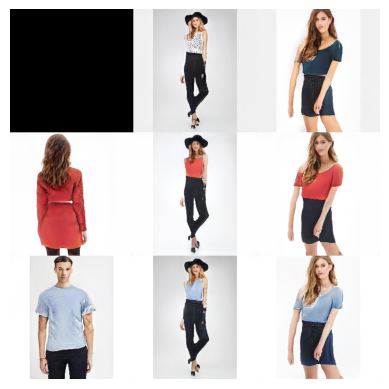

In [18]:
print('Loading no pose networks from "%s"...' % ckpt)
whole_seeds = list(set(rows + cols))
generator = Generator(z_dim=512, w_dim=512, c_dim=0, img_resolution=256, img_channels=3,
                      batch_size=1, mapping_kwargs={'num_layers': 2},
                      synthesis_kwargs={'channel_base': 16384,
                                        'channel_max': 512,
                                        'num_fp16_res': 4,
                                        'conv_clamp': 256})
param_dict = load_checkpoint(ckpt)
load_param_into_net(generator, param_dict)

clip_min = Tensor(0, ms.float32)
clip_max = Tensor(255, ms.float32)

os.makedirs(out_dir, exist_ok=True)

print('Generating W vectors...')
whole_z = np.stack([np.random.RandomState(seed).randn(generator.z_dim) for seed in whole_seeds])
whole_w = generator.mapping.construct(Tensor(whole_z, ms.float32), None)
w_avg = generator.mapping.w_avg
whole_w = w_avg + (whole_w - w_avg) * truncation_psi
w_dict = {seed: w for seed, w in zip(whole_seeds, list(whole_w))}
image_dict = dict()
print('Generating images...')
for i in range(whole_w.shape[0]):
    image = generator.synthesis.construct(whole_w[i][np.newaxis], noise_mode=noise_mode)
    image = ops.clip_by_value(image.transpose(0, 2, 3, 1) * 127.5 + 128, clip_min, clip_max).astype(ms.uint8)
    image_dict[(whole_seeds[i], whole_seeds[i])] = image.asnumpy()[0]

print('Generating style-mixed images...')
for row_seed in rows:
    for col_seed in cols:
        w = w_dict[row_seed].copy()
        w[col_styles] = w_dict[col_seed][col_styles]
        image = generator.synthesis.construct(w[np.newaxis], noise_mode=noise_mode)
        image = ops.clip_by_value(image.transpose(0, 2, 3, 1) * 127.5 + 128, clip_min, clip_max).astype(ms.uint8)
        image_dict[(row_seed, col_seed)] = image.asnumpy()[0]

print('Saving images...')
os.makedirs(out_dir, exist_ok=True)
for (row_seed, col_seed), image in image_dict.items():
    PIL.Image.fromarray(image, 'RGB').save(f'{out_dir}/{row_seed}-{col_seed}.png')

print('Saving image grid...')
ww = generator.img_resolution
hh = generator.img_resolution
out = PIL.Image.new('RGB', (ww * (len(cols) + 1), hh * (len(rows) + 1)), 'black')
for row_idx, row_seed in enumerate([0] + rows):
    for col_idx, col_seed in enumerate([0] + cols):
        if row_idx == 0 and col_idx == 0:
            continue
        key = (row_seed, col_seed)
        if row_idx == 0:
            key = (col_seed, col_seed)
        if col_idx == 0:
            key = (row_seed, row_seed)
        out.paste(PIL.Image.fromarray(image_dict[key], 'RGB'), (ww * col_idx, hh * row_idx))
out.save(f'{out_dir}/grid.png')
img = PIL.Image.open(f'{out_dir}/grid.png')
plt.figure()
plt.imshow(img)
plt.axis("off")
plt.show()

注：上面这段代码运行时会报若干警告，是模型导入时没有找到对应参数，这些警告是由于在模型在construct中需要使用conv2d和transpose2d，但由于Mindspore限制，无法在construct里定义conv2d，并赋予新的权重，因此这一系列conv2d和transpose2d被调整到了模型的init中，但是它们的权重需要在construct过程中获得，因此在init时会给它们随机初始化。这些权重并不是需要训练的模型参数，因此不会出现在保存的checkpoint中，从而导致了导入预训练模型时，会出现如上警告，为正常可解释现象。此外上述代码运行时会输出部分变量的值，这同样是由于上述问题在construct时需要输出也可以运行。

### 模型推理可视化

由于硬件资源问题，上方的代码中仅提供了3×3的结果，如果资源允许，可以增加数据量进行推理。下方给出在服务器上生成的5×5的结果图。

Mindspore推理结果:

<img src='./images/grid_mindspore.png' width=50% height=50%/>

Pytorch推理结果:

<img src='./images/grid_pytorch.png' width=50% height=50%/>

Mindspore的推理结果与Pytorch源代码推理结果完全一致，这是令人满意的。

另一方面，需要指出的是，由于作者没有开源代码，我们不能复现出与原文完全一样的推理结果图。考虑到本项目的目标是实现试穿这一操作，我们已经完成了该操作，且该操作得到的效果与论文中的一致。下方给出了论文中的推理结果图以供参考。

论文中结果：

<img src='./images/demo.png' width=50% height=50%/>

### 封装损失函数

接下来介绍模型训练相关内容，首先是封装损失函数。由于损失函数并不是常用交叉熵损失，库中没有直接可以调用的接口，因此需要自己编写CustomWithLossCell对损失函数进行封装。

In [19]:
class CustomWithLossCell(nn.Cell):
    """
    CustomWithLossCell for training.

    Args:
        g_mapping (nn.Cell): Generator mapping network.
        g_synthesis (nn.Cell): Generator synthesis network.
        discriminator (nn.Cell): Discriminator.
        style_gan_loss (nn.Cell): StyleGAN loss.

    Inputs:
        - **do_gmain** (bool) - Conduct the generator.
        - **do_dmain** (bool) - Conduct the discriminator.
        - **real_img** (Tensor) - Real images.
        - **pose** (Tensor) - Poses.
        - **real_c** (Tensor) - Real labels.
        - **gen_z** (Tensor) - Latent tensor.
        - **gen_c** (Tensor) - Latent labels.
        - **gain** (Tensor) - Loss gain.

    Outputs:
        Tensor, a float tensor representing the total loss.

    Supported Platforms:
        ``Ascend`` ``GPU`` ``CPU``

    Examples:
        >>> cal_loss = CustomWithLossCell(generator.mapping, generator.synthesis, discriminator, StyleGANLoss)
        >>> network = nn.TrainOneStepCell(cal_loss, opt)
        >>> network(do_gmain, do_dmain, real_img, pose, real_c, gen_z, gen_c, gain)
    """
    def __init__(self, g_mapping, g_synthesis, discriminator, style_gan_loss):
        super(CustomWithLossCell, self).__init__()
        self.g_mapping = g_mapping
        self.g_synthesis = g_synthesis
        self.discriminator = discriminator
        self.style_gan_loss = style_gan_loss(self.g_mapping, self.g_synthesis, self.discriminator)

    def construct(self, do_gmain, do_dmain, real_img, pose, real_c, gen_z, gen_c, gain):
        """CustomWithLossCell construct"""
        loss = self.style_gan_loss.accumulate_gradients(do_gmain, do_dmain, real_img, pose, real_c, gen_z, gen_c, gain)
        return loss

### 模型训练

通过实例化数据集、网络、损失函数、优化器等，对模型进行训练。训练思路大致为，针对数据集的每一个batch，初始化潜在向量$z$，结合姿态数据作为生成器的输入，对于鉴别器来说，输入除了需要包括生成器输入外，还需要包括真实图片。模型训练过程中会按照指定snap保存模型与生成的图片。由于训练工程量很大，时间成本高，不建议在jupyter notebook中进行训练。

另一方面，需要指出的是，由于作者没有开源代码，这里采用的是github中他人复现的pytorch源代码，该代码工程中提供的模型训练与模型结构部分存在以下漏洞。在训练过程中，无论是否使用姿态数据，最终都会指向不使用姿态数据。在源代码中，使用姿态数据情况下，在训练forward时，需要更改网络结构，但所提供的checkpoint文件中并没有此结构，因此会导致变量形状不匹配。在确保模型结果不变的情况下，姿态数据实际并没有被用到，这导致了模型训练效果较差。由于源代码中的这个问题，笔者暂未找到解决方案能够优化训练效果，希望感兴趣的同行可以进一步钻研。

首先进行一些输入的定义。

In [7]:
import argparse
import copy
import os
import re
import time

import numpy as np
import PIL.Image
from mindspore import load_checkpoint, load_param_into_net
import mindspore as ms
from mindspore import Tensor, ops, nn, set_seed

from models.vogue_generator import Generator
from models.vogue_discriminator import Discriminator
from process_datasets.inshop import Inshop
from losses.vogue_loss import CustomWithLossCell, StyleGANLoss

os.environ['GLOG_v'] = '3'
ms.set_context(mode=ms.PYNATIVE_MODE)
out_dir = 'src/out/' # Output directory
gpus = 1 # Number of GPUs to use
snap = 10 # Snapshot interval
random_seed = 0 # Random seed
data_dir = './dataset/data.zip' # Data path
posefile = 'src/pose-annotations.csv' # Pose keypoints path
mirror = False # Enable dataset x-flips
total_kimg = 25000 # Total training duration
batch_size = 2 # Total batch size
model_path = 'src/ckpt/' # Path to save models

image_snapshot_ticks = snap # Image interval
network_snapshot_ticks = snap # Network interval
cur_tick = 0 # Current tick
batch_idx = 0 # Batch id
cur_nimg = 0 # Current image number
kimg_per_tick = 4 # Image number per tick
tick_start_nimg = 2404000 # Starting image number
cur_nimg = 2404000 # The current image number
abort_fn = None # Abort training flag
all_done = False # Training done flag

# Model related setting
g_reg_interval = 4 # Generator interval
d_reg_interval = 16 # Discriminator interval
g_mapping_kwargs = {'num_layers': 2} # G_mapping kwargs
g_synthesis_kwargs = {'channel_base': 16384, 'channel_max': 512,
                      'num_fp16_res': 4, 'conv_clamp': 256} # G_synthesis kwargs
d_epilogue_kwargs = {'mbstd_group_size': 4} # D_epilogue kwargs
g_opt_kwargs = {'class_name': 'mindspore.nn.Adam', 'lr': 0.0025, 'betas': [1e-08, 0.99], 'eps': 1e-08} # G optimizer kwargs
d_opt_kwargs = {'class_name': 'mindspore.nn.Adam', 'lr': 0.0025, 'betas': [1e-08, 0.99], 'eps': 1e-08} # D optimizer kwargs

# Random initialization
np.random.seed(random_seed)
set_seed(random_seed)

# Operator initialization
concat = ops.Concat()
split_batch = ops.Split(0, output_num=2)
split_gpu = ops.Split(0)

In [8]:
def setup_snapshot_image_grid(dataset, seed=0):
    """
    Return the image grid size and images, labels, poses。

    Args:
        dataset (class): The dataset.
        seed (int): Random seed. Default: 0.

    Returns:
        tuple, the image grid size.
        numpy.ndarray, images.
        numpy.ndarray, labels.
        numpy.ndarray, poses.

    Examples:
        >>> size, images, labels, pose = setup_snapshot_image_grid(dataset)
    """
    rnd = np.random.RandomState(seed)
    gw = 4
    gh = 4

    if not dataset.has_labels:
        all_indices = list(range(len(dataset)))
        rnd.shuffle(all_indices)
        grid_indices = [all_indices[i % len(all_indices)] for i in range(gw * gh)]

    else:
        label_groups = {}
        for idx in range(len(dataset)):
            label = tuple(dataset.get_details(idx).raw_label.flat[::-1])
            if label not in label_groups:
                label_groups[label] = []
            label_groups[label].append(idx)

        label_order = sorted(label_groups.keys())
        for label in label_order:
            rnd.shuffle(label_groups[label])

        grid_indices = []
        for y in range(gh):
            label = label_order[y % len(label_order)]
            indices = label_groups[label]
            grid_indices += [indices[x % len(indices)] for x in range(gw)]
            label_groups[label] = [indices[(i + gw) % len(indices)] for i in range(len(indices))]

    data_images, data_labels, data_pose = zip(*[dataset[i] for i in grid_indices])
    grid = (gw, gh)
    out_images = np.stack(data_images)
    out_labels = np.stack(data_labels)
    out_pose = np.stack(data_pose)
    return grid, out_images, out_labels, out_pose


def save_image_grid(s_image, f_name, d_range, size):
    """
    Save grid image.

    Args:
        s_image (numpy.ndarray): The image.
        f_name (str): The file path.
        d_range (list): Image range.
        size (tuple): Image size.

    Examples:
        >>> save_image_grid(images, path, d_range=[0, 255], size=grid_size)
    """
    lo, hi = d_range
    s_image = np.asarray(s_image, dtype=np.float32)
    s_image = (s_image - lo) * (255 / (hi - lo))
    s_image = np.rint(s_image).clip(0, 255).astype(np.uint8)

    gw, gh = size
    _, cc, hh, ww = s_image.shape
    s_image = s_image.reshape(gh, gw, cc, hh, ww)
    s_image = s_image.transpose(0, 3, 1, 4, 2)
    s_image = s_image.reshape(gh * hh, gw * ww, cc)

    if cc == 1:
        PIL.Image.fromarray(s_image[:, :, 0], 'L').save(f_name)
    if cc == 3:
        PIL.Image.fromarray(s_image, 'RGB').save(f_name)


def save_model(module_list, out_dir, cur_nimg):
    """
    Save model.

    Args:
        module_list (list): A list of module names and modules.
        out_dir (str): The output directory.
        cur_nimg (int): Current image number.

    Examples:
        >>> save_image_grid(module_list, 'out/', 10)
    """
    for name, module in module_list:
        module_copy = copy.deepcopy(module)
        for key, value in module_copy.parameters_dict().items():
            if 'all_conv' in key:
                value.requires_grad = False
        module_copy.requires_grad = False
        all_param = []
        for par in module_copy.trainable_params():
            layer = dict()
            layer['name'] = par.name
            layer['data'] = par
            all_param.append(layer)
        ms.save_checkpoint(all_param, out_dir + f'network-snapshot-{cur_nimg // 1000:06d}-' + name + '.ckpt')
        del module_copy


def save_image_snapshot(out_dir, cur_nimg, model, grid_z, grid_c, grid_pose, grid_size, concat):
    """
    Save image snapshot.

    Args:
        out_dir (str): The output directory.
        cur_nimg (int): Current image number.
        model (nn.Cell): Generator_ema infer model.
        grid_z (tuple): Noise.
        gird_c (tuple): Labels.
        grid_pose (tuple): Poses.
        grid_size (tuple): The image grid size.
        concat (Operation): Concat operator.

    Examples:
        >>> save_image_snapshot(out_dir, cur_nimg, model, grid_z, grid_c, grid_pose, grid_size, concat)
    """
    param_dict = load_checkpoint(out_dir + f'network-snapshot-{cur_nimg // 1000:06d}-G_ema.ckpt')
    load_param_into_net(model, param_dict)
    images = []
    for z, c, pose in zip(grid_z, grid_c, grid_pose):
        ws = model.mapping.construct(z=z, c=c)
        image = model.synthesis.construct(ws=ws, pose=pose, noise_mode=0)
        images.append(image)
    images = concat(images).asnumpy()
    save_image_grid(images, os.path.join(out_dir, f'fakes{cur_nimg // 1000:06d}.png'), d_range=[-1, 1], size=grid_size)

# Load dataset
training_set = Inshop(path=data_dir, pose_file=posefile, resize=256, use_labels=False,
                      max_size=48674, xflip=mirror, batch_size=batch_size)
batch_num = len(training_set) // batch_size

if not os.path.exists(out_dir):
    os.mkdir(out_dir)
grid_size, images, labels, pose = setup_snapshot_image_grid(dataset=training_set)
save_image_grid(images, os.path.join(out_dir, 'reals.png'), d_range=[0, 255], size=grid_size)

# Load infer model
generator_ema_infer = Generator(z_dim=512, w_dim=512, c_dim=0,
                                img_resolution=256, img_channels=3, batch_size=images.shape[0],
                                mapping_kwargs=g_mapping_kwargs, synthesis_kwargs=g_synthesis_kwargs)
param_dict = load_checkpoint(os.path.join(model_path, 'G_ema.ckpt'))
load_param_into_net(generator_ema_infer, param_dict)

grid_z = split_gpu(Tensor(np.random.randn(labels.shape[0], generator_ema_infer.z_dim), ms.float32))
grid_c = split_gpu(Tensor(labels, ms.float32))
grid_pose = split_gpu(Tensor(pose, ms.float32))
imgs = []
for z, c, pose in zip(grid_z, grid_c, grid_pose):
    ws = generator_ema_infer.mapping.construct(z=z, c=c)
    img = generator_ema_infer.synthesis.construct(ws=ws, pose=pose, noise_mode=0)
    imgs.append(img)
imgs = concat(imgs).asnumpy()
save_image_grid(imgs, os.path.join(out_dir, 'fakes_init.png'), d_range=[-1, 1], size=grid_size)

print('Num images: ', len(training_set), '\nImage shape: ', training_set.image_shape,
      '\nLabel shape:', training_set.label_shape)

start_time = time.time()

# Load train model
generator = Generator(z_dim=512, w_dim=512, c_dim=0,
                      img_resolution=256, img_channels=3, batch_size=batch_size, train=True,
                      mapping_kwargs=g_mapping_kwargs, synthesis_kwargs=g_synthesis_kwargs)
generator_ema = copy.deepcopy(generator)
for key, value in generator_ema.parameters_dict().items():
    if 'all_conv' in key:
        value.requires_grad = False
discriminator = Discriminator(c_dim=0, img_resolution=256, img_channels=3, block_kwargs={},
                              mapping_kwargs={}, epilogue_kwargs=d_epilogue_kwargs, batch_size=batch_size,
                              channel_base=16384, channel_max=512, num_fp16_res=4, conv_clamp=256)

module_list = [('G', generator), ('D', discriminator), ('G_ema', generator_ema)]

for model_name, module in module_list:
    param_dict = load_checkpoint(os.path.join(model_path, model_name + '.ckpt'))
    load_param_into_net(module, param_dict)

cal_loss = CustomWithLossCell(generator.mapping, generator.synthesis, discriminator, StyleGANLoss)

phases = []
for name, module, opt_kwargs, reg_interval in [('G', generator, g_opt_kwargs, g_reg_interval),
                                               ('D', discriminator, d_opt_kwargs, d_reg_interval)]:
    mb_ratio = reg_interval / (reg_interval + 1)
    opt_kwargs['lr'] = opt_kwargs['lr'] * mb_ratio
    opt_kwargs['betas'] = [beta ** mb_ratio for beta in opt_kwargs['betas']]
    opt = nn.Adam(module.get_parameters(), learning_rate=Tensor(np.array(opt_kwargs['lr']), ms.float32),
                  beta1=opt_kwargs['betas'][0], beta2=opt_kwargs['betas'][1], eps=opt_kwargs['eps'])
    network = nn.TrainOneStepCell(cal_loss, opt)
    network.set_train()
    phases.append({'name': name + 'main', 'module': module, 'opt': opt, 'interval': 1, 'network': network})


tick_start_time = time.time()
maintenance_time = tick_start_time - start_time
while True:
    for num in range(batch_num):
        (whole_real_img, whole_real_c, whole_pose) = training_set.get_all(num)
        whole_real_img = split_gpu((Tensor(whole_real_img, ms.float32) / 127.5 - 1))
        whole_real_c = split_gpu(Tensor(whole_real_c, ms.float32))
        whole_pose = split_gpu(Tensor(whole_pose, ms.float32))
        whole_gen_z = Tensor(np.random.randn(len(phases) * batch_size, generator.z_dim), ms.float32)
        whole_gen_z = [split_gpu(whole_gen_z) for whole_gen_z in split_batch(whole_gen_z)]
        whole_gen_c = [training_set.get_label(np.random.randint(len(training_set))) for _ in
                       range(len(phases) * batch_size)]
        whole_gen_c = Tensor(np.stack(whole_gen_c), ms.float32)
        whole_gen_c = [split_gpu(whole_gen_c) for whole_gen_c in split_batch(whole_gen_c)]

        for phase, whole_gen_z, whole_gen_c in zip(phases, whole_gen_z, whole_gen_c):
            if batch_idx % phase['interval'] != 0:
                continue
            phase['module'].requires_grad = True

            # Calculate loss
            for (real_img, pose, real_c, gen_z, gen_c) in \
                    zip(whole_real_img, whole_pose, whole_real_c, whole_gen_z, whole_gen_c):
                gain = phase['interval']
                do_gmain = (phase['name'] in ['Gmain', 'Gboth'])
                do_dmain = (phase['name'] in ['Dmain', 'Dboth'])
                loss = phase['network'](do_gmain, do_dmain, real_img, pose, real_c, gen_z, gen_c, gain)
                print('%s loss: %f' % (phase['name'], loss))
            phase['module'].requires_grad = False

        # Update parameters for g_ema
        ema_kimg = 5.0
        ema_nimg = ema_kimg * 1000
        ema_beta = 0.5 ** (batch_size / max(ema_nimg, 1e-8))
        for p_ema, p in zip(generator_ema.get_parameters(), generator.get_parameters()):
            value = (p + (p_ema - p) * ema_beta).copy()
            p_ema.set_data(value)

        # Update state
        cur_nimg += batch_size
        batch_idx += 1

        # Perform maintenance tasks once per tick
        done = (cur_nimg >= total_kimg * 1000)
        if (not done) and (cur_tick != 0) and (cur_nimg < tick_start_nimg + kimg_per_tick * 1000):
            continue

        # Print status line, accumulating the same information in stats_collector
        tick_end_time = time.time()
        print('Progress/tick: %5d' % (cur_tick))
        print('Progress/kimg: %8.1f' % (cur_nimg / 1e3))
        print('Timing/total_sec: %12s' % (tick_end_time - start_time))
        print('Timing/sec_per_tick: %7.1f' % (tick_end_time - tick_start_time))
        print(
            'Timing/sec_per_kimg: %7.2f' % ((tick_end_time - tick_start_time) / (cur_nimg - tick_start_nimg) * 1e3))
        print('Timing/maintenance_sec: %6.1f' % (maintenance_time))
        print('Timing/total_hours: ', (tick_end_time - start_time) / (60 * 60))
        print('Timing/total_days: ', (tick_end_time - start_time) / (24 * 60 * 60))

        # Check for abort
        if (not done) and (abort_fn is not None):
            done = True
            print('Aborting...')

        # Save network snapshot
        if (network_snapshot_ticks is not None) and (done or cur_tick % network_snapshot_ticks == 0):
            save_model(module_list, out_dir, cur_nimg)

        # Save image snapshot
        if (image_snapshot_ticks is not None) and (done or cur_tick % image_snapshot_ticks == 0):
            save_image_snapshot(out_dir, cur_nimg, generator_ema_infer, grid_z, grid_c, grid_pose,
                                grid_size, concat)

        # Update state
        cur_tick += 1
        tick_start_nimg = cur_nimg
        tick_start_time = time.time()
        maintenance_time = tick_start_time - tick_end_time
        if done:
            all_done = True
            break
    if all_done:
        break
# Done
print('Exiting...')

Num images:  48674 
Image shape:  [1, 2, 3] 
Label shape: 1
Gmain loss: 0.817177
Dmain loss: 1.375431
Progress/tick:     0
Progress/kimg:   2404.0
Timing/total_sec: 141.97554731369019
Timing/sec_per_tick:   133.8
Timing/sec_per_kimg: 66898.33
Timing/maintenance_sec:    8.2
Timing/total_hours:  0.03943765203158061
Timing/total_days:  0.0016432355013158587
Gmain loss: 0.756225
Dmain loss: 1.229593
Gmain loss: 0.841111
Dmain loss: 0.902835
Gmain loss: 1.180353
Dmain loss: 0.691465



注：上面这段代码运行时会报若干警告，是模型导入时没有找到对应参数，这些警告是由于在模型在construct中需要使用conv2d和transpose2d，但由于Mindspore限制，无法在construct里定义conv2d，并赋予新的权重，因此这一系列conv2d和transpose2d被调整到了模型的init中，但是它们的权重需要在construct过程中获得，因此在init时会给它们随机初始化。这些权重并不是需要训练的模型参数，因此不会出现在保存的checkpoint中，从而导致了导入预训练模型时，会出现如上警告，为正常可解释现象。此外上述代码运行时会输出部分变量的值，这同样是由于上述问题在construct时需要输出也可以运行。

## 总结

本案例对VOGUE的原理进行分析，并详细介绍了VOGUE的实现细节，并在模型推理中复现了pytorch的效果。如需查看其他代码，请参考MindSpore Vision套件。

## 参考文献

[1] Lewis K M, Varadharajan S, Kemelmacher-Shlizerman I. [Vogue: Try-on by stylegan interpolation optimization](https://arxiv.org/pdf/2101.02285v1.pdf)\[J\]. arXiv:2101.02285, 2021.

[2] Lewis K M, Varadharajan S, Kemelmacher-Shlizerman I. [TryOnGAN: Body-Aware Try-On via Layered Interpolation](https://arxiv.org/pdf/2101.02285.pdf)\[J\]. ACM Transactions on Graphics (TOG), 2021, 40(4): 1-10.

[3] Karras T, Laine S, Aittala M, et al. [Analyzing and improving the image quality of stylegan](https://openaccess.thecvf.com/content_CVPR_2019/papers/Karras_A_Style-Based_Generator_Architecture_for_Generative_Adversarial_Networks_CVPR_2019_paper.pdf)\[C\]. Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2020: 8110-8119.

[4] Karras T, Laine S, Aila T. [A style-based generator architecture for generative adversarial networks](https://openaccess.thecvf.com/content_CVPR_2020/papers/Karras_Analyzing_and_Improving_the_Image_Quality_of_StyleGAN_CVPR_2020_paper.pdf)\[C\]. Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2019: 4401-4410.